# **Random Forests**

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Botswana', 'Country_Serbia', 'Country_Peru', 'Country_United Arab Emirates', 'Country_Yemen', 'Country_Viet Nam', 'Country_Saudi Arabia', 'Country_Nomadic', 'Country_Lebanon', 'Country_Philippines', 'Country_Costa Rica', 'Country_Uzbekistan', 'Country_Sri Lanka', 'Country_Estonia', 'Country_Andorra', 'Country_Cyprus', 'Country_New Zealand', 'Country_Mongolia', 'Country_Latvia', 'Country_El Salvador', 'Country_Slovakia', 'Country_Georgia', 'Country_Bangladesh', 'Country_Azerbaijan', 'Country_Bosnia-Herz.', 'Country_Angola', 'Ethnicity_North American / Central American', 'Country_Armenia', 'Country_Venezuela', 'Country_Kenya', 'Country_North Macedonia', 'Country_Kosovo', 'Country_Zimbabwe', 'Country_Paraguay', 'Country_Tanzania', 'Country_Malta', 'Country_Croatia', 'Country_Jordan'}
Columns in the test set that aren't in the train set: {'Country_Qatar', 'Country_Belarus', 'Country_Republic of Korea', 'Country_Barbados', 'Cou

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,12.2,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2258, 92)
(2258,)

(553, 92)
(553,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = train_df['Annual_salary']
# y_test = test_df['Annual_salary']
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [8]:
model = RandomForestRegressor(random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(100, 1000),
    "max_features": randint(30, X_train_scaled.shape[1]//2), # Reducido
    "max_depth": randint(20, 40), # Reducido
    "min_samples_split": randint(2, 12), # Ampliado un poco
    "min_samples_leaf": randint(1, 5), # Reducido
    "bootstrap": [True, False],
}


scorer = {'r2': make_scorer(r2_score, greater_is_better=True), 
          'rmse': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'bootstrap': True, 'max_depth': 26, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 373}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [9]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.777533,0.611090,23985.101937,31654.495245
1,0.778797,0.610202,23916.878605,31694.139304
2,0.750321,0.608266,25409.148111,31769.251179
3,0.748790,0.608371,25486.954746,31764.734205
4,0.870152,0.585823,18324.447013,32661.224107
5,0.827701,0.598967,21108.724963,32139.693685
6,0.933168,0.573207,13145.573775,33161.106534
7,0.905542,0.605922,15629.447145,31877.418207
8,0.835298,0.614150,20637.545845,31540.441627
9,0.850963,0.601125,19632.611782,32060.271421


Now, the average of folds:

In [10]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  

print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Test R2: 0.601712246011491
Mean CV Test RMSE: 32032.27755148338


In [11]:
# Creando un DataFrame vacío
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  # Obtiene el número de splits directamente del objeto KFold

# Llenando el DataFrame con los resultados
for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  # RMSE se multiplica por -1
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    # RMSE se multiplica por -1
        }
        results_df = results_df.append(fold_results, ignore_index=True)

# Ajustando el índice para que muestre el número de fold
results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.780477,0.57948,24029.57454,32103.395926
2,0.781723,0.581708,23961.29537,32018.253478
3,0.753799,0.579383,25447.883705,32107.123861
4,0.752364,0.579521,25521.919704,32101.858732
5,0.867329,0.541106,18680.772721,33536.201345
6,0.82951,0.559636,21176.565255,32852.158928
7,0.930824,0.530789,13489.106388,33911.111415
8,0.905036,0.57934,15804.711732,32108.74354
9,0.836872,0.588879,20714.310781,31742.625189


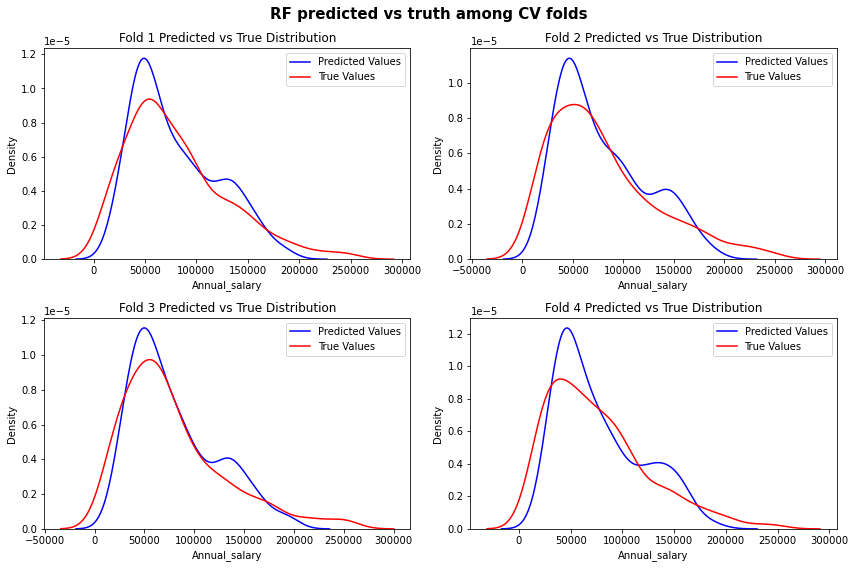

In [12]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    # Extrae los datos para este fold específico
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    # Realiza las predicciones para este fold
    y_fold_pred = clf.predict(X_fold_test)

    # Crear un subplot para cada fold
    plt.subplot(2, 2, fold_num)
    sns.kdeplot(y_fold_pred, color='blue', label='Predicted Values')
    sns.kdeplot(y_fold_true, color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1
plt.suptitle('RF predicted vs truth among CV folds', weight='bold', fontsize=15)

plt.tight_layout()
plt.show()


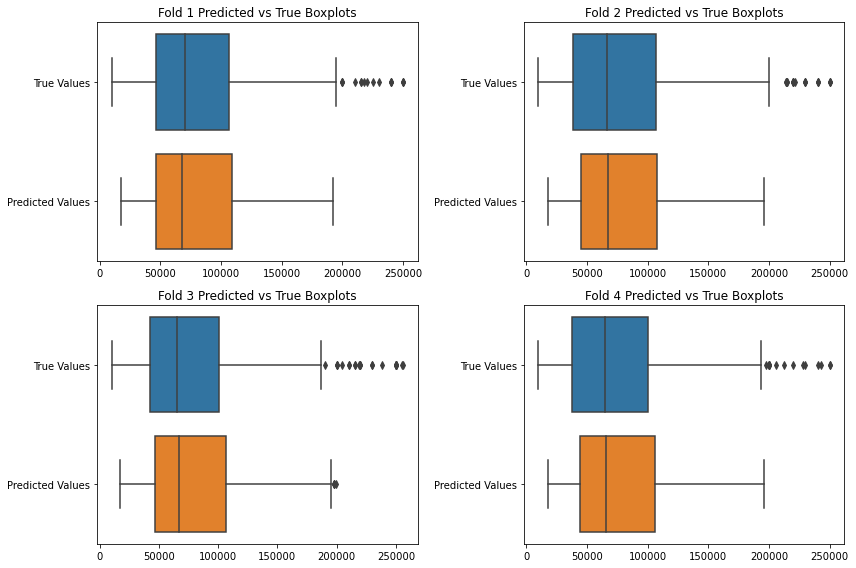

In [13]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.boxplot(data=[y_fold_true, y_fold_pred], orient='h')
    plt.yticks(ticks=[0, 1], labels=['True Values', 'Predicted Values'])
    plt.title(f'Fold {fold_num} Predicted vs True Boxplots')

    fold_num += 1

plt.tight_layout()
plt.show()


### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [14]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: 0.8343129997215858
RMSE: 20701.915450405933
Adjusted R^2: 0.8272722588321566


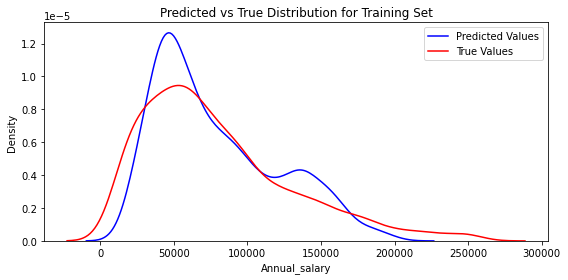

In [15]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")
    
y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(y_train_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_train, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6478252669766462
RMSE: 29406.69942728058
Adjusted R^2: 0.5773903203719755


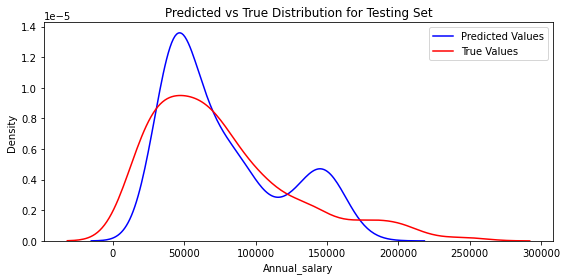

In [16]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")
    
y_test_pred = clf.best_estimator_.predict(X_test_scaled)

# Configuración del gráfico
plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(y_test_pred, color='blue', label='Predicted Values')
sns.kdeplot(y_test, color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

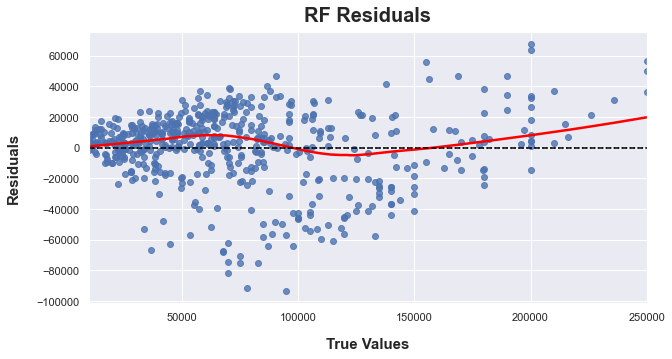

In [18]:
sns.set_theme(style='darkgrid')

residuals = y_test - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('RF Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/rf-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

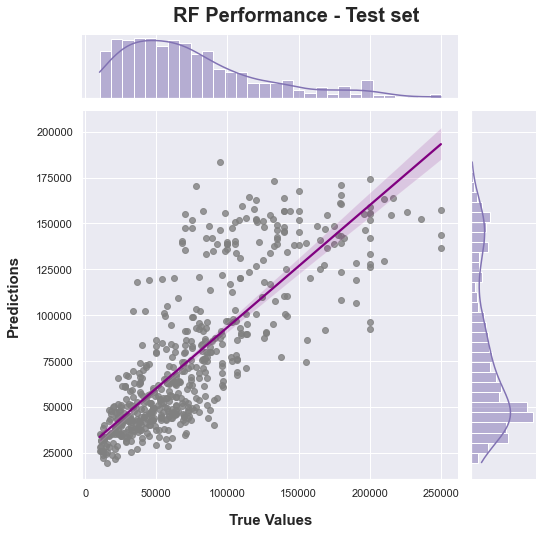

In [19]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=y_test, y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('RF Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/rf-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [20]:
df_cv_results.to_csv("../../output/rf-cv-results.csv")

Saving train and test sets predictions

In [21]:
np.savetxt("../../output/rf-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/rf-test-predictions.csv", y_pred_test, delimiter=",")

In [22]:
pd.set_option('display.max_colwidth', None)


df_cv_results[['params', 'mean_train_r2', 'mean_test_r2' , 'mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'bootstrap': True, 'max_depth': 39, 'max_features': 42, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 800}",0.777533,0.611090,23985.101937,31654.495245
1,"{'bootstrap': True, 'max_depth': 26, 'max_features': 39, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 430}",0.778797,0.610202,23916.878605,31694.139304
2,"{'bootstrap': True, 'max_depth': 23, 'max_features': 37, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 761}",0.750321,0.608266,25409.148111,31769.251179
3,"{'bootstrap': True, 'max_depth': 21, 'max_features': 37, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 485}",0.748790,0.608371,25486.954746,31764.734205
4,"{'bootstrap': False, 'max_depth': 20, 'max_features': 41, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 352}",0.870152,0.585823,18324.447013,32661.224107
5,"{'bootstrap': False, 'max_depth': 36, 'max_features': 40, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 575}",0.827701,0.598967,21108.724963,32139.693685
6,"{'bootstrap': False, 'max_depth': 35, 'max_features': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 975}",0.933168,0.573207,13145.573775,33161.106534
7,"{'bootstrap': True, 'max_depth': 39, 'max_features': 45, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 584}",0.905542,0.605922,15629.447145,31877.418207
8,"{'bootstrap': True, 'max_depth': 26, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 373}",0.835298,0.614150,20637.545845,31540.441627
9,"{'bootstrap': False, 'max_depth': 33, 'max_features': 31, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 445}",0.850963,0.601125,19632.611782,32060.271421


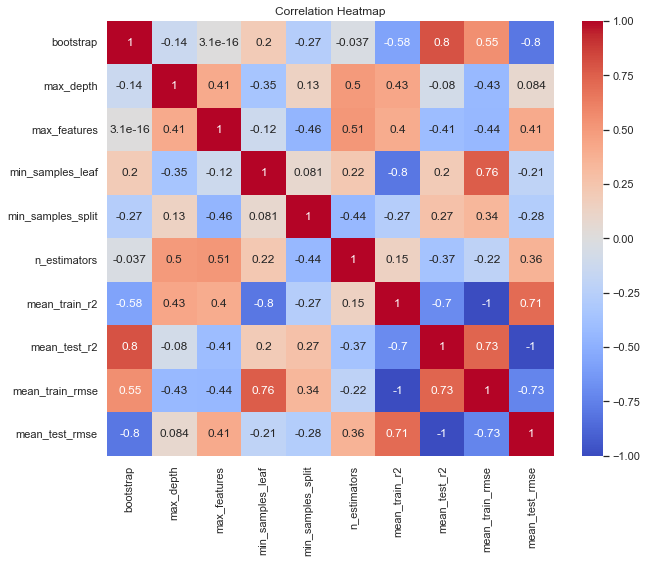

In [23]:
df_subset = df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

# Extraer las características de la columna 'params' en columnas individuales
params_df = df_subset['params'].apply(pd.Series)
df_processed = pd.concat([params_df, df_subset[['mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]], axis=1)

# Convertir valores de 'bootstrap' a números
df_processed['bootstrap'] = df_processed['bootstrap'].astype(int)

# Calcular la correlación de Pearson
corr = df_processed.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

From this correlation map we can guess:

- Better when boostrap = True
- Max depth the better
- Reduce max features, min_samples_leaf and add more min_samples_split
